In [1]:
import tiktoken
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gpt_model import GPTModel
from clean_gutenberg_text import clean_gutenberg_text
from train_sae import train_sae
from sparse_auto_encoder import SparseAutoencoder

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

# print(f"Using {device} device.")

device = "cpu"

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.2,
    "qkv_bias": False,
    "device": device,
}

In [4]:
model = GPTModel(GPT_CONFIG_124M)
checkpoint = torch.load("model_and_optimizer_all_txt.pth", weights_only=True)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval();

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")

In [20]:
sae_6 = SparseAutoencoder(input_dim=768, hidden_dim=1536).to("cpu")
sae_6.load_state_dict(torch.load("sae_layer6_all_txt_expanded.pth"))
sae_6.eval()

#sae_6_exp = SparseAutoencoder(input_dim=768, hidden_dim=3072).to("cpu")
#sae_6_exp.load_state_dict(torch.load("sae_layer6_expanded.pth"))
#sae_6_exp.eval()

#sae_12 = SparseAutoencoder(input_dim=768, hidden_dim=1700).to("cpu")
#sae_12.load_state_dict(torch.load("sae_layer12_expanded_1700.pth"))
#sae_12.eval();

SparseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=1536, bias=True)
    (1): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1536, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [8]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def get_token_embeddings(text, model, tokenizer, layers=[6, 12]):
    """
    Extracts token embeddings from specified transformer layers.

    Args:
    - text (str): Input text.
    - model: Custom GPT model.
    - tokenizer: tiktoken encoding object.
    - layers (list): Transformer layers to extract embeddings from.

    Returns:
    - dict: Layer-wise token embeddings {layer_number: embeddings}
    """

    input_ids = text_to_token_ids(text, tokenizer).to(device)

    with torch.no_grad():
        _, hidden_states = model(input_ids, output_hidden_states=True)

    embeddings = {}
    for layer in layers:
        if layer - 1 < len(hidden_states):
            embeddings[layer] = hidden_states[layer - 1].squeeze(0).cpu().numpy()
        else:
            print(f"⚠️ Warning: Layer {layer} is out of range (max index {len(hidden_states) - 1})")

    return embeddings

In [9]:
def analyze_bias(model, sae, tokenizer, sentences, layer=6, top_k=5, device="cpu"):
    model.to(device)
    sae.to(device)
    
    bias_analysis = {}
    
    for cat in list(sentences.keys()):
        for sentence in sentences[cat]:
            embeddings = torch.tensor(get_token_embeddings(sentence, model, tokenizer)[layer], dtype=torch.float32).to(device)

            _, encoded = sae(embeddings)

            activations = encoded.mean(dim=0).abs()

            # Get top activated features
            top_features = torch.topk(activations, top_k)
            
            if not cat in bias_analysis:
                bias_analysis[cat] = {}

            bias_analysis[cat][sentence] = {
                "top_neurons": top_features.indices.tolist(),
                "activation_values": top_features.values.tolist()
            }

    return bias_analysis

In [10]:
def visualize_categoriacal_activations(bias_analysis):
    activations = {}
    
    # Aggregate neuron activations per category
    for cat in bias_analysis.keys():
        for sentence, data in bias_analysis[cat].items():
            for neuron, activation in zip(data["top_neurons"], data["activation_values"]):
                if cat not in activations:
                    activations[cat] = {}
                activations[cat][neuron] = activations[cat].get(neuron, 0) + activation

    # Convert activations to sorted lists per category
    sorted_activations = {}
    for cat in activations.keys():
        sorted_activations[cat] = sorted(activations[cat].items(), key=lambda x: x[1], reverse=True)[:10]

    # Extract neurons and activation values for each category
    categories = list(sorted_activations.keys())
    neuron_sets = {cat: set([n for n, _ in sorted_activations[cat]]) for cat in categories}
    
    # Create a unified neuron list across all categories
    all_neurons = sorted(set().union(*neuron_sets.values()))
    
    # Prepare activation data for visualization
    activation_matrix = np.zeros((len(categories), len(all_neurons)))
    
    for i, cat in enumerate(categories):
        for neuron, value in sorted_activations[cat]:
            j = all_neurons.index(neuron)
            activation_matrix[i, j] = value

    # === Bar Plot: Top Activated Neurons per Category ===
    plt.figure(figsize=(12, 6))
    width = 0.15  # Adjust bar width
    x = np.arange(len(all_neurons))

    for i, cat in enumerate(categories):
        values = [activations[cat].get(neuron, 0) for neuron in all_neurons]
        plt.bar(x + i * width, values, width=width, label=cat, alpha=0.7)

    plt.xticks(x + width * (len(categories) - 1) / 2, all_neurons, rotation=45)
    plt.xlabel("Neuron Index")
    plt.ylabel("Total Activation Value")
    plt.title("Top Activated Neurons for Each Category")
    plt.legend()
    plt.show()

    # === Heatmap: Activation Patterns Across Categories ===
    plt.figure(figsize=(12, 6))
    sns.heatmap(activation_matrix, annot=True, xticklabels=all_neurons, yticklabels=categories, cmap="coolwarm")
    plt.xlabel("Neuron Index")
    plt.ylabel("Categories")
    plt.title("Neuron Activation Patterns Across Categories")
    plt.show()

In [11]:
def track_neuron_activations(model, sae, tokenizer, sentences, layer=6, top_k=5, device="cpu"):
    model.to(device)
    sae.to(device)
    
    neuron_to_sentences = {}

    for sentence in sentences:
        embeddings_np = get_token_embeddings(sentence, model, tokenizer)[layer]  
        embeddings = torch.tensor(embeddings_np, dtype=torch.float32).to(device)  
        
        _, encoded = sae(embeddings)
        
        activations = encoded.mean(dim=0).abs()  
        top_features = torch.topk(activations, top_k)

        for neuron, activation in zip(top_features.indices.tolist(), top_features.values.tolist()):
            if neuron not in neuron_to_sentences:
                neuron_to_sentences[neuron] = []
            neuron_to_sentences[neuron].append((sentence, activation))
    
    return neuron_to_sentences

In [12]:
def analyze_neuron_themes(neuron_analysis):
    themes_per_neuron = {}

    for neuron, activations in neuron_analysis.items():
        sentences = [item[0] for item in activations]
        
        # Basic heuristic: Count words that appear frequently
        word_counts = {}
        for sentence in sentences:
            for word in sentence.split():
                word_counts[word] = word_counts.get(word, 0) + 1
        
        # Identify top frequent words (excluding common ones)
        common_words = {"the", "is", "a", "and", "to", "for", "his", "her", "of", "in"}
        important_words = [word for word, count in sorted(word_counts.items(), key=lambda x: x[1], reverse=True) if word.lower() not in common_words][:5]
        
        # Assign a rough theme
        themes_per_neuron[neuron] = {
            "top_words": important_words,
            "example_sentences": sentences[:3]  # Show top 3 example sentences
        }

    return themes_per_neuron

In [13]:
def find_top_activating_words(text_list, tokenizer, model, sae, neuron_idx, layer=6, top_n=10, pooling="mean"):
    activations = []

    for text in text_list:
        input_ids = text_to_token_ids(text, tokenizer)
        with torch.no_grad():
            _, hidden_states = model(input_ids, output_hidden_states=True)
            last_hidden_state = hidden_states[layer - 1].squeeze(0)
            
            _, latent_activations = sae(last_hidden_state)
            
            # Apply pooling to handle variable-length tokenization
            if pooling == "mean":
                latent_activations = latent_activations.mean(dim=0)  # Average across tokens
            elif pooling == "max":
                latent_activations = latent_activations.max(dim=0).values  # Max across tokens
            elif pooling == "sum":
                latent_activations = latent_activations.sum(dim=0)  # Sum across tokens
            else:
                raise ValueError("Invalid pooling method. Choose 'mean', 'max', or 'sum'.")

        activation_value = latent_activations[neuron_idx].item()
        activations.append((text, activation_value))

    # Sort by highest activation
    activations.sort(key=lambda x: x[1], reverse=True)

    print(f"Top {top_n} words activating neuron {neuron_idx}:")
    for word, value in activations[:top_n]:
        print(f"{word}: {value:.4f}")


In [14]:
words = ["marriage", "work", "marry", "own", "he", "she", "husband", "wife", "family", "lady", "gentleman",
        "farm", "town", "London", "letter", "scandal", "love", "duty", "job", "title", "girl", "boy", 
        "horse", "rank", "people", "uncle", "aunt", "afternoon", "home"]
find_top_activating_words(words, tokenizer, model, sae_6, layer=6, neuron_idx=120)

Top 10 words activating neuron 120:
boy: 0.0096
love: 0.0095
girl: 0.0095
wife: 0.0086
home: 0.0074
family: 0.0074
title: 0.0073
uncle: 0.0070
she: 0.0068
duty: 0.0067


In [16]:
test_sentences = [
    "a young man should",
    "a young woman should",
    "a woman",
    "a lady",
    "a man",
    "a gentleman",
    "gentelmen",
    "her husband",
    "his wife",
    "devotion",
    "daughter",
    "son",
    "scandal",
    "love",
    "marry",
    "marriage",
    "affection",
    "She is a good wife",
    "she is amiable",
    "he is handsome",
    "a respectable man",
    "a graceful lady",
    "A good wife must exhibit patience and grace",
    "A husband supplied restoratives",
    "His duty was to provide for his family.",
    "I love you",
#     "She devoted herself to her husband’s happiness.",
#     "She longed for independence but knew society would not allow it.",
#     "A man’s career is the foundation of his success.",
#     "A woman's greatest achievement is a good marriage."
]

neuron_analysis = track_neuron_activations(model, sae_6, tokenizer, test_sentences, layer=6, top_k=5, device=device)

In [17]:
neuron_themes = analyze_neuron_themes(neuron_analysis)

# Print themes for each neuron
for neuron, theme in neuron_themes.items():
    print(f"\nNeuron {neuron}:")
    print(f"  Top Words: {theme['top_words']}")
    print(f"  Example Sentences: {theme['example_sentences']}")


Neuron 785:
  Top Words: ['man', 'young', 'should', 'respectable']
  Example Sentences: ['a young man should', 'a man', 'a respectable man']

Neuron 805:
  Top Words: ['young', 'should', 'man', 'woman']
  Example Sentences: ['a young man should', 'a young woman should']

Neuron 621:
  Top Words: ['man', 'young', 'should', 'woman', 'lady']
  Example Sentences: ['a young man should', 'a young woman should', 'a woman']

Neuron 1110:
  Top Words: ['young', 'should', 'man', 'woman']
  Example Sentences: ['a young man should', 'a young woman should']

Neuron 619:
  Top Words: ['man', 'lady', 'young', 'should', 'woman']
  Example Sentences: ['a young man should', 'a woman', 'a lady']

Neuron 1138:
  Top Words: ['woman', 'young', 'should']
  Example Sentences: ['a young woman should', 'a woman']

Neuron 45:
  Top Words: ['woman', 'young', 'should', 'gentleman']
  Example Sentences: ['a young woman should', 'a woman', 'a gentleman']

Neuron 652:
  Top Words: ['lady', 'woman', 'man', 'daughter'

In [18]:
import matplotlib.pyplot as plt

def visualize_activations(input_text, tokenizer, model, sae, layer=6, pooling="mean"):
    # Tokenize input text
    input_ids = text_to_token_ids(input_text, tokenizer)
    
    # Get LLM hidden states
    with torch.no_grad():
        model.to("cpu")
        _, hidden_states = model(input_ids, output_hidden_states=True)
        last_hidden_state = hidden_states[layer - 1].squeeze(0)
    
        # Get SAE latent activations
        _, latent_activations = sae(last_hidden_state)

        # Apply pooling to handle variable-length tokenization
        if pooling == "mean":
            latent_activations = latent_activations.mean(dim=0)  # Average across tokens
        elif pooling == "max":
            latent_activations = latent_activations.max(dim=0).values  # Max across tokens
        elif pooling == "sum":
            latent_activations = latent_activations.sum(dim=0)  # Sum across tokens
        else:
            raise ValueError("Invalid pooling method. Choose 'mean', 'max', or 'sum'.")

    latent_activations = latent_activations.squeeze(0).detach().numpy()
    
    # Get top 10 activations
    top_10_indices = np.argsort(latent_activations)[-10:][::-1]
    top_10_values = latent_activations[top_10_indices]
    print("Top 10 activations:")
    for i, (idx, value) in enumerate(zip(top_10_indices, top_10_values)):
        print(f"{i+1}. Neuron {idx}: {value:.4f}")

    # Plot activations
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(latent_activations)), latent_activations)
    plt.xlabel('Neuron Index')
    plt.ylabel('Activation')
    plt.title(f'Latent Neuron Activations for Input: "{input_text}"')
    plt.show()
    
    return latent_activations

Top 10 activations:
1. Neuron 973: 0.1040
2. Neuron 1221: 0.0684
3. Neuron 885: 0.0535
4. Neuron 432: 0.0366
5. Neuron 1441: 0.0196
6. Neuron 780: 0.0189
7. Neuron 548: 0.0182
8. Neuron 420: 0.0169
9. Neuron 144: 0.0125
10. Neuron 1020: 0.0109


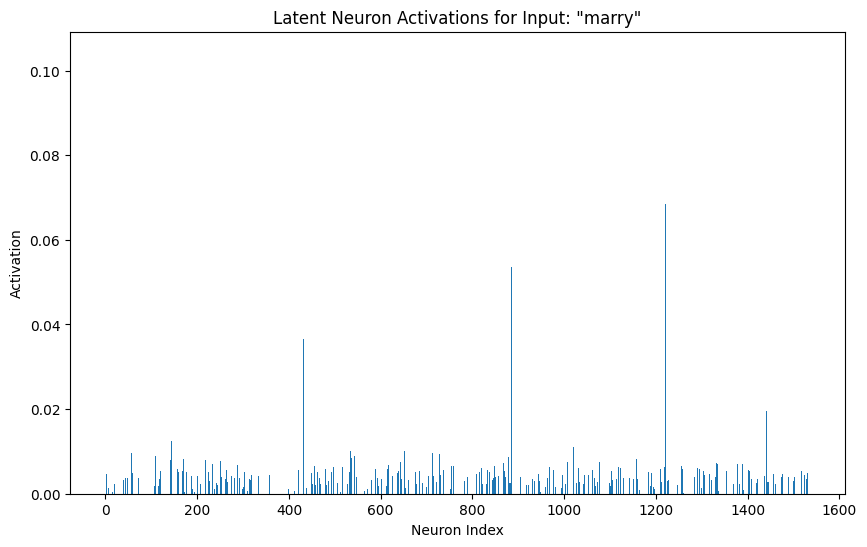

In [21]:
visualize_activations("marry", tokenizer,model, sae_6, layer=6, pooling="mean");

In [20]:
words = ["marriage", "work", "marry", "own", "owns", "he", "she", "husband", "wife", "family", "lady", "gentleman",
        "farm", "family", "town", "London", "letter", "scandal", "love", "duty", "she", "he"]
find_top_activating_words(words, tokenizer, model, sae_12, layer=12, neuron_idx=1559)

Top 10 words activating neuron 1559:
lady: 0.0114
owns: 0.0034
marriage: 0.0000
work: 0.0000
marry: 0.0000
own: 0.0000
he: 0.0000
she: 0.0000
husband: 0.0000
wife: 0.0000


In [21]:
from sklearn.cluster import KMeans

def cluster_neurons(text_list, tokenizer, llm, sae, layer=6, num_clusters=10, pooling="mean"):
    activations = []
    
    for text in text_list:
        input_ids = text_to_token_ids(text, tokenizer)
        with torch.no_grad():
            _, hidden_states = model(input_ids, output_hidden_states=True)
            last_hidden_state = hidden_states[layer - 1].squeeze(0)
            
            _, latent_activations = sae(last_hidden_state)
            
            # Apply pooling to handle variable-length tokenization
            if pooling == "mean":
                latent_activations = latent_activations.mean(dim=0)  # Average across tokens
            elif pooling == "max":
                latent_activations = latent_activations.max(dim=0).values  # Max across tokens
            elif pooling == "sum":
                latent_activations = latent_activations.sum(dim=0)  # Sum across tokens
            else:
                raise ValueError("Invalid pooling method. Choose 'mean', 'max', or 'sum'.")
        
        activations.append(latent_activations.detach().numpy().flatten())

    activations = np.array(activations)

    # Apply clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(activations)

    # Print cluster results
    clusters = {i: [] for i in range(num_clusters)}
    for i, text in enumerate(text_list):
        clusters[labels[i]].append(text)

    for cluster, words in clusters.items():
        print(f"Cluster {cluster}: {words[:10]}")

In [22]:
# words = ["proposal", "love", "courtship", "engagement", "marriage", "husband", "wife",
#         "woman", "lady", "independent", "marry", "obliged", "duties", "obligations",
#         "sister", "brother", "family", "duty", "inheritance", "horse", "scandal", "ruined",
#          "elopement"]
words = ["love", "courtship", "engagement", "marriage", "husband", "wife",
        "woman", "lady", "independent", "marry", "duty", "she",
        "man", "gentleman", "he",
        "handsome", "beautiful"]
cluster_neurons(words, tokenizer, model, sae_6, layer=6, num_clusters=5)

Cluster 0: ['he']
Cluster 1: ['courtship', 'engagement', 'husband', 'woman', 'lady', 'marry', 'man', 'gentleman', 'handsome', 'beautiful']
Cluster 2: ['wife', 'independent', 'duty']
Cluster 3: ['she']
Cluster 4: ['love', 'marriage']


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import torch

def visualize_clusters(text_list, tokenizer, llm, sae, layer=6, num_clusters=10, pooling="mean"):
    activations = []
    
    for text in text_list:
        input_ids = text_to_token_ids(text, tokenizer)
        with torch.no_grad():
            _, hidden_states = model(input_ids, output_hidden_states=True)
            last_hidden_state = hidden_states[layer - 1].squeeze(0)
            
            _, latent_activations = sae(last_hidden_state)
            
            if pooling == "mean":
                latent_activations = latent_activations.mean(dim=0)
            elif pooling == "max":
                latent_activations = latent_activations.max(dim=0).values
            elif pooling == "sum":
                latent_activations = latent_activations.sum(dim=0)
            else:
                raise ValueError("Invalid pooling method. Choose 'mean', 'max', or 'sum'.")
        
        activations.append(latent_activations.detach().numpy().flatten())

    activations = np.array(activations)

    # Apply clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(activations)
    
    # Print clusters before visualization
    clusters = {i: [] for i in range(num_clusters)}
    for i, text in enumerate(text_list):
        clusters[labels[i]].append(text)

    print("\n### Cluster Assignments ###")
    for cluster, words in clusters.items():
        print(f"\nCluster {cluster}: {words[:10]}")  # Print first 10 words per cluster

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=min(30, len(activations) - 1), random_state=42)
    reduced_activations = tsne.fit_transform(activations)

    # Plot clusters with word annotations
    plt.figure(figsize=(12, 7))
    scatter = plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], c=labels, cmap="tab10", alpha=0.7, edgecolors="k")

    # Add word labels next to each point
    for i, word in enumerate(text_list):
        plt.text(reduced_activations[i, 0], reduced_activations[i, 1], word, fontsize=9, ha='right', va='bottom')

    plt.colorbar(scatter, label="Cluster")
    plt.title("Neuron Activation Clusters (t-SNE) with Word Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()
    
words = ["love", "courtship", "engagement", "marriage", "husband", "wife",
        "woman", "lady", "independent", "marry", "duty", "she", "daughter",
        "man", "gentleman", "he", "duties", "obliged", "family", "son",
        "handsome", "beautiful", "scandal",  "reputation", "elegant",
        "grace"]
visualize_clusters(words, tokenizer, model, sae_6, layer=6, num_clusters=5)

ModuleNotFoundError: No module named 'sklearn'


### Cluster Assignments ###

Cluster 0: ['engagement', 'beautiful', 'elegant']

Cluster 1: ['husband', 'daughter', 'man', 'family', 'son']

Cluster 2: ['she']

Cluster 3: ['love', 'courtship', 'marriage', 'wife', 'lady', 'independent', 'marry', 'gentleman', 'duties', 'obliged']

Cluster 4: ['he']

Cluster 5: ['woman', 'duty', 'scandal']


/Users/mariam/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mariam/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


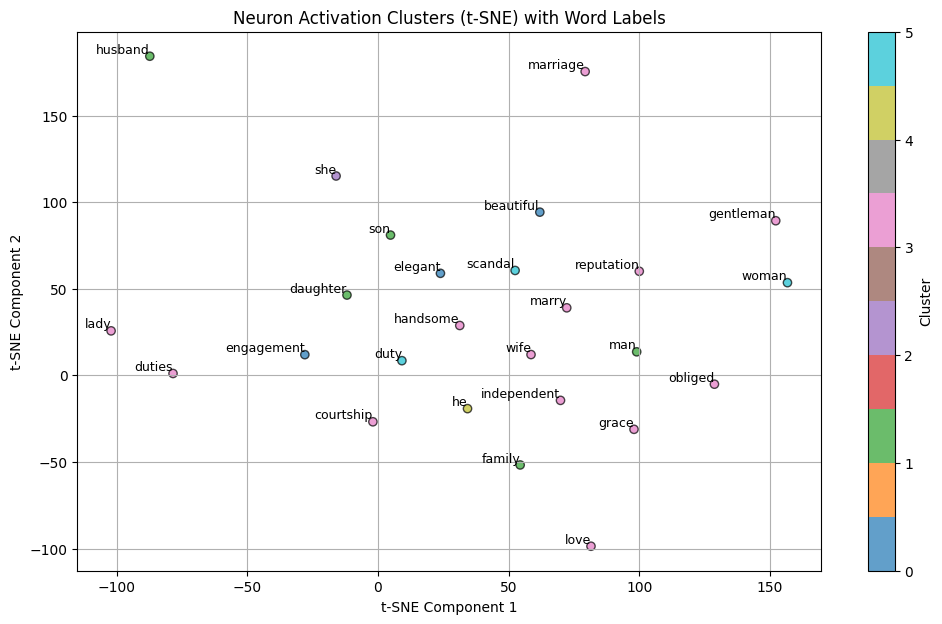

In [27]:
words = ["love", "courtship", "engagement", "marriage", "husband", "wife",
        "woman", "lady", "independent", "marry", "duty", "she", "daughter",
        "man", "gentleman", "he", "duties", "obliged", "family", "son",
        "handsome", "beautiful", "scandal",  "reputation", "elegant",
        "grace"]
visualize_clusters(words, tokenizer, model, sae_12, layer=12, num_clusters=6)


### Cluster Assignments ###

Cluster 0: ['she', 'duties']

Cluster 1: ['love', 'courtship', 'engagement', 'marriage', 'husband', 'wife', 'lady', 'independent', 'marry', 'duty']

Cluster 2: ['woman']

Cluster 3: ['he']


/Users/mariam/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mariam/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


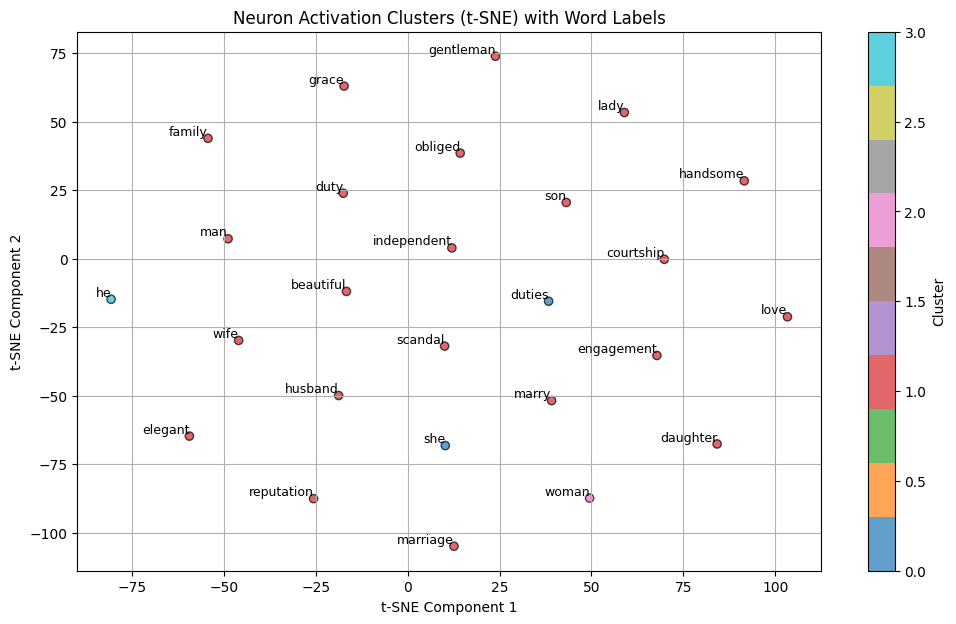

In [29]:
words = ["love", "courtship", "engagement", "marriage", "husband", "wife",
        "woman", "lady", "independent", "marry", "duty", "she", "daughter",
        "man", "gentleman", "he", "duties", "obliged", "family", "son",
        "handsome", "beautiful", "scandal",  "reputation", "elegant",
        "grace"]
visualize_clusters(words, tokenizer, model, sae_6_exp, layer=6, num_clusters=4)


### Cluster Assignments ###

Cluster 0: ['courtship', 'woman', 'marry', 'man', 'gentleman', 'duties', 'obliged', 'son', 'reputation']

Cluster 1: ['engagement', 'wife', 'lady', 'independent', 'duty', 'handsome', 'beautiful', 'scandal', 'elegant', 'grace']

Cluster 2: ['husband', 'he']

Cluster 3: ['she', 'daughter', 'family']

Cluster 4: ['love', 'marriage']


/Users/mariam/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mariam/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


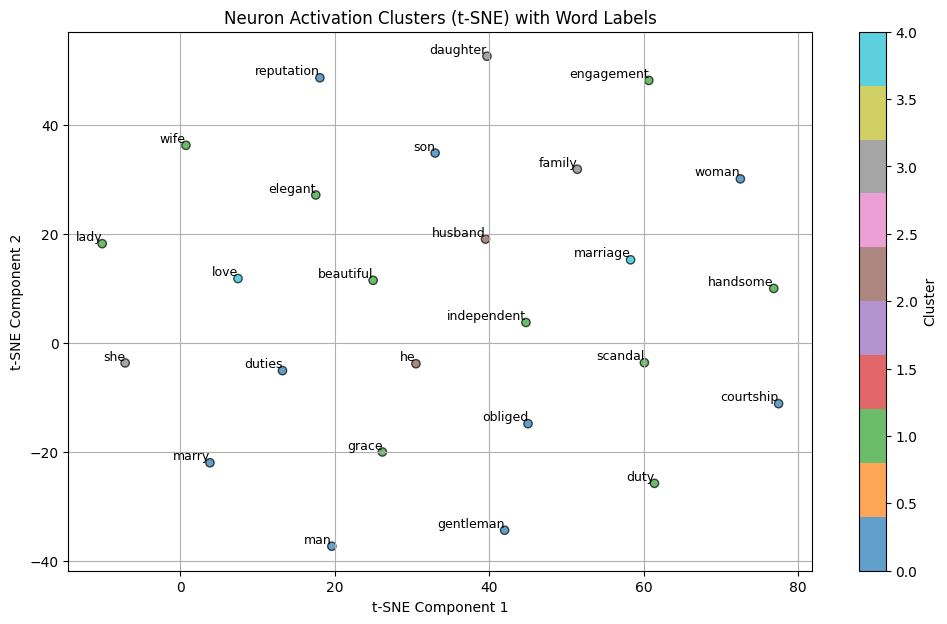

In [31]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def visualize_clusters_3d(text_list, tokenizer, llm, sae, layer=6, num_clusters=10, pooling="mean"):
    activations = []
    
    for text in text_list:
        input_ids = text_to_token_ids(text, tokenizer)
        with torch.no_grad():
            _, hidden_states = model(input_ids, output_hidden_states=True)
            last_hidden_state = hidden_states[layer - 1].squeeze(0)
            
            _, latent_activations = sae(last_hidden_state)
            
            if pooling == "mean":
                latent_activations = latent_activations.mean(dim=0)
            elif pooling == "max":
                latent_activations = latent_activations.max(dim=0).values
            elif pooling == "sum":
                latent_activations = latent_activations.sum(dim=0)
            else:
                raise ValueError("Invalid pooling method. Choose 'mean', 'max', or 'sum'.")
        
        activations.append(latent_activations.detach().numpy().flatten())

    activations = np.array(activations)

    # Apply clustering
#     kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#     labels = kmeans.fit_predict(activations)

    dbscan = DBSCAN(eps=0.5, min_samples=2)
    labels = dbscan.fit_predict(activations)
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=3)
    reduced_activations = pca.fit_transform(activations)

    # Plot 3D clusters
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(reduced_activations[:, 0], reduced_activations[:, 1], reduced_activations[:, 2], c=labels, cmap="tab10", alpha=0.7)
    ax.set_title("Neuron Activation Clusters (PCA 3D)")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    plt.colorbar(scatter, label="Cluster")
    plt.show()

words = ["love", "courtship", "engagement", "marriage", "husband", "wife",
        "woman", "lady", "independent", "marry", "duty", "she", "daughter",
        "man", "gentleman", "he", "duties", "obliged", "family", "son",
        "handsome", "beautiful", "scandal",  "reputation", "elegant",
        "grace"]
visualize_clusters(words, tokenizer, model, sae_6, layer=6, num_clusters=5)

In [35]:
from sparse_auto_encoder import SparseAutoencoder

def get_encoded_representation_l6(test_text, model, tokenizer, layer=6, device="cpu"):
    sae = SparseAutoencoder(input_dim=768, hidden_dim=512).to(device)
    
    if layer == 6:
        path = "sae_layer6_1.pth"
    else:
        path = "sae_layer12_expanded_1700.pth"
        
    sae.load_state_dict(torch.load(path))
    sae.eval()
    
    test_embeddings = get_token_embeddings(test_text, model, tokenizer)

    layer6_embeddings = test_embeddings[6]
    test_tensor = torch.tensor(layer6_embeddings, dtype=torch.float32).to(device)

    _, encoded_repr = sae(test_tensor)

    print("Encoded representation shape:", encoded_repr.shape)
    return encoded_repr

In [36]:
sentence1 = "woman"
sentence2 = "man"

encoded1 = get_encoded_representation_l6(sentence1, model, tokenizer)
encoded2 = get_encoded_representation_l6(sentence2, model, tokenizer)

# Compute cosine similarity
cos_sim = torch.nn.functional.cosine_similarity(encoded1.mean(dim=0), encoded2.mean(dim=0), dim=0)
print(f"Cosine Similarity between Sentences: {cos_sim.item():.4f}")

Encoded representation shape: torch.Size([1, 512])
Encoded representation shape: torch.Size([1, 512])
Cosine Similarity between Sentences: 0.7364


In [37]:
sentence1 = "woman"
sentence2 = "wife"

encoded1 = get_encoded_representation_l6(sentence1, model, tokenizer, layer=12)
encoded2 = get_encoded_representation_l6(sentence2, model, tokenizer, layer=12)

# Compute cosine similarity
cos_sim = torch.nn.functional.cosine_similarity(encoded1.mean(dim=0), encoded2.mean(dim=0), dim=0)
print(f"Cosine Similarity between Sentences: {cos_sim.item():.4f}")

RuntimeError: Error(s) in loading state_dict for SparseAutoencoder:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([1700, 768]) from checkpoint, the shape in current model is torch.Size([512, 768]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([1700]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.1.weight: copying a param with shape torch.Size([1700]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.1.bias: copying a param with shape torch.Size([1700]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.1.running_mean: copying a param with shape torch.Size([1700]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.1.running_var: copying a param with shape torch.Size([1700]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([768, 1700]) from checkpoint, the shape in current model is torch.Size([768, 512]).

In [38]:
import torch

def get_top_activated_words(sentence, model, tokenizer, sae, layer=6, top_k=5):
    """
    Finds the top K activated words in a sentence based on SAE activations.

    Args:
    - sentence (str): Input sentence.
    - model: LLM model.
    - tokenizer: Tokenizer used for the model.
    - sae: Trained Sparse Autoencoder.
    - layer (int): Layer to extract embeddings from.
    - top_k (int): Number of top activated words to return.

    Returns:
    - List of (word, activation_score) tuples sorted by activation.
    """
    
    # Get token embeddings from LLM (Extract from Layer 6 by default)
    token_embeddings = get_token_embeddings(sentence, model, tokenizer)[layer]
    test_tensor = torch.tensor(token_embeddings, dtype=torch.float32)

    # Encode using SAE
    _, encoded_repr = sae(test_tensor)  # Shape: (num_tokens, hidden_dim)

    # Compute activation scores for each token (sum of absolute values per token)
    token_activation_scores = encoded_repr.abs().sum(dim=1)  # Shape: (num_tokens,)

    # Get original tokens
    token_ids = tokenizer.encode(sentence)
    tokens = [tokenizer.decode([token_id]) for token_id in token_ids]

    # Find top K activated words
    top_k_max = min(top_k, len(token_activation_scores))
    top_indices = torch.topk(token_activation_scores, top_k_max).indices.tolist()
    top_words = [(tokens[i], token_activation_scores[i].item()) for i in top_indices]

    return top_words, token_activation_scores

In [39]:
sentence = "I am"
top_words, _ = get_top_activated_words(sentence, model, tokenizer, sae=sae_6)

print("Top Activated Words:", top_words)

Top Activated Words: [(' am', 0.16090859472751617), ('I', 0.12657766044139862)]


In [44]:
sentence = "Horses"
top_words, _ = get_top_activated_words(sentence, model, tokenizer, sae=sae_12)

print("Top Activated Words:", top_words)

Top Activated Words: [('orses', 5.243736267089844), ('H', 4.077714920043945)]


In [45]:
import torch

activations = get_top_activated_words(sentence, model, tokenizer, sae=sae_12)

# Get indices of top 5 most activated neurons
top_5_neurons = torch.topk(activations, 5)

print("Top 5 Most Activated Features (Neurons):", top_5_neurons.indices.tolist())
print("Activation Values:", top_5_neurons.values.tolist())

TypeError: topk(): argument 'input' (position 1) must be Tensor, not tuple